# Download Data

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

C:\Users\ACER\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# open file txt and using list to store data
file_path = "diabetes_scale.txt"  # file path
data = [] 

# Open and read the "diabetes_scale.txt" file
with open(file_path, "r") as file:
    for line in file:
        # Split each line into individual values
        values = line.strip().split()

        # Initialize a dictionary to store the data for this line
        data_dict = {}

        # The first value is the outcome
        data_dict['outcome'] = int(values[0])

        # Parse the rest of the values and map them to column names
        for pair in values[1:]:
            index, value = pair.split(':')
            column_name = {
                '1': 'pregnancies',
                '2': 'glucose',
                '3': 'blood_pressure',
                '4': 'skin_thickness',
                '5': 'insulin',
                '6': 'bmi',
                '7': 'diabetes_pedigree_function',
                '8': 'age'
            }[index]
            data_dict[column_name] = float(value)

        # Append the dictionary to the cleaned_data list
        data.append(data_dict)

# Convert the list of dictionaries into a pandas DataFrame
cleaned_data = pd.DataFrame(data)
cleaned_data

,outcome,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
0,-1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,-1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,-1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000
...,...,...,...,...,...,...,...,...,...
763,1,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000
764,1,-0.764706,0.226131,0.147541,-0.454545,-1.000000,0.096870,-0.776260,-0.800000
765,1,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000
766,-1,-0.882353,0.266332,-0.016393,-1.000000,-1.000000,-0.102832,-0.768574,-0.133333


# Cleaning Data

Missing value will be detected. After that, histrogram will be plotted to analyse distribution to impute missing value. If distribution is not symetic, missing value will be imputed by mode of data. If distribution is symetic, missing value will be imputed by median of data.

In [3]:
# check missing value
cleaned_data.isnull().sum()

outcome                       0
pregnancies                   0
glucose                       0
blood_pressure                1
skin_thickness                0
insulin                       0
bmi                           0
diabetes_pedigree_function    0
age                           8
dtype: int64

The blood_pressure and the age  contain missing value.

### Ploting distribution

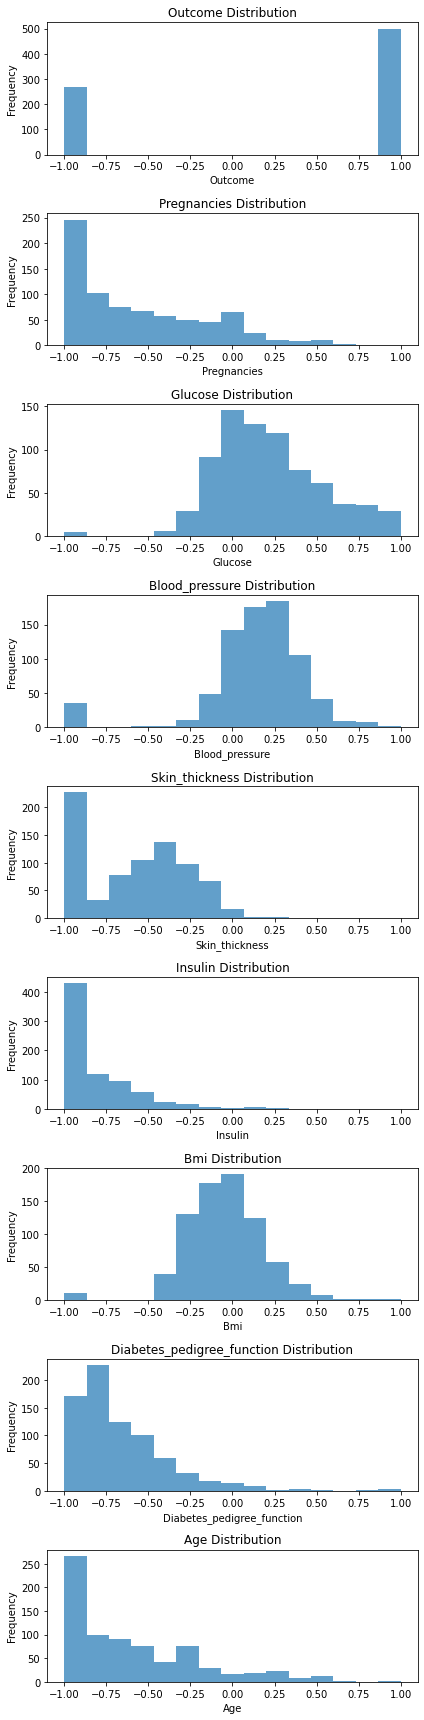

In [4]:
# Create a figure with subplots for each column
fig, axes = plt.subplots(len(cleaned_data.columns), 1, figsize=(6, 24))

# Iterate through each column and create a histogram subplot
for i, column in enumerate(cleaned_data.columns):
    axes[i].hist(cleaned_data[column], bins=15, alpha=0.7)
    axes[i].set_xlabel(column.capitalize())  # Set the column name as the x-axis label
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{column.capitalize()} Distribution')

# Adjust spacing between subplots
plt.tight_layout()

# Show the individual plots
plt.show()

Since the blood_pressure and the age has missing value and has normal distribution (with outliers) and right skewed distribution  , respectively. Thus, missing value of blood_pressure will be imputed by mean of blood_pressure, while missing value of age will be imputed by mode of age.

### Imputing missing value

In [5]:
blood_pressure_mean = cleaned_data['blood_pressure'].mean() # mean of blood_pressure
age_mode = cleaned_data['age'].mode().values[0] # mode of age

# Impute missing values in "blood_pressure" with the mean
cleaned_data['blood_pressure'].fillna(blood_pressure_mean, inplace=True)

# Impute missing values in "age" with the mode
cleaned_data['age'].fillna(age_mode, inplace=True)

# recheck missing value
cleaned_data.isnull().sum()

outcome                       0
pregnancies                   0
glucose                       0
blood_pressure                0
skin_thickness                0
insulin                       0
bmi                           0
diabetes_pedigree_function    0
age                           0
dtype: int64

In [6]:
# Check format of data
cleaned_data

,outcome,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
0,-1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,-1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,-1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000
...,...,...,...,...,...,...,...,...,...
763,1,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000
764,1,-0.764706,0.226131,0.147541,-0.454545,-1.000000,0.096870,-0.776260,-0.800000
765,1,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000
766,-1,-0.882353,0.266332,-0.016393,-1.000000,-1.000000,-0.102832,-0.768574,-0.133333


The outcome is labelled -1 and 1.   1 in outcome has to be 0 and -1 in outcome has to be 1. Thus, -1 and 1 will be replaced by 1 and 0, respectively.

In [7]:
previous_data = cleaned_data

# Replace 1 with 0 and -1 with 1 in the "outcome" column
cleaned_data['outcome'] = cleaned_data['outcome'].replace({1: 0, -1: 1})
cleaned_data

,outcome,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
0,1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,0,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,0,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000
...,...,...,...,...,...,...,...,...,...
763,0,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000
764,0,-0.764706,0.226131,0.147541,-0.454545,-1.000000,0.096870,-0.776260,-0.800000
765,0,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000
766,1,-0.882353,0.266332,-0.016393,-1.000000,-1.000000,-0.102832,-0.768574,-0.133333


# MLP

The data will be splitted into training and testing set. MLP is defined using the Keras API from TensorFlow, with the architecture's hyperparameters being adjustable. These hyperparameters include the choice of activation functions (ReLU, Sigmoid, and Tanh), the number of hidden layers, the number of neurons per layer, whether to include batch normalisation, dropout rates, and the regularisation rates for each layer.

To optimise these hyperparameters,  Keras Tuner's Random Search method is applied. This method will search through a random selection of possible hyperparameters, train models with these parameters, and then select the best model based on validation accuracy. The Random Search is set to conduct a maximum of 5 trials, with each trial being executed 3 times, to ensure the reliability of the results.

Once the search is completed, the code sorts the trials based on their performance. Then, the best model and its associated hyperparameters are identified for each type of activation function (ReLU, Sigmoid, and Tanh) that was considered during the tuning. Finally, the best hyperparameters will be showed for each activation function and provides an opportunity to view the structure of the best-performing model with the ReLU activation.

## Data preparation

In [8]:
# set seed
np.random.seed(1865050)
tf.random.set_seed(1865050)

# setting X and Y
X = cleaned_data.drop('outcome', axis=1)
y = cleaned_data['outcome']

# Split data to training set (80%) and testing set(20%) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1865050, stratify=y)

## Hyperparameter tuning using Keras Tuner

In [9]:
from kerastuner import RandomSearch
import tensorflow as tf
from tensorflow.keras import layers

def build_model(hp):
    model = tf.keras.Sequential()
    
    activation_choice = hp.Choice('activation_function', ['relu', 'sigmoid', 'tanh'])

    # Input layer
    model.add(layers.Dense(units=hp.Int('units_input', min_value=64, max_value=256, step=32),
                           activation=activation_choice,
                           kernel_regularizer=tf.keras.regularizers.l2(hp.Float('reg_rate', 0.001, 0.05, step=0.005)),
                           input_shape=(X_train.shape[1],)))
    
    if hp.Boolean('batch_norm_input'):
        model.add(layers.BatchNormalization(
            momentum=hp.Float('batch_norm_momentum_input', min_value=0.9, max_value=0.999, step=0.01),
            epsilon=hp.Float('batch_norm_epsilon_input', min_value=1e-7, max_value=1e-5, sampling='LOG')
        ))
    
    model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Hidden layers
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                               activation=activation_choice,
                               kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'reg_rate_{i}', 0.001, 0.05, step=0.005))))
        
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(layers.BatchNormalization(
                momentum=hp.Float(f'batch_norm_momentum_{i}', min_value=0.9, max_value=0.999, step=0.01),
                epsilon=hp.Float(f'batch_norm_epsilon_{i}', min_value=1e-7, max_value=1e-5, sampling='LOG')
            ))
        
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i+1}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='diabetes_mlp',
    project_name='diabetes'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get all trials and sort by their performance (objective)
sorted_trials = sorted(tuner.oracle.trials.values(), key=lambda trial: trial.score, reverse=True)  # Assuming higher is better

def get_best_model_and_params_by_condition(condition_key, condition_value):
    for trial in sorted_trials:
        if trial.hyperparameters.values.get(condition_key) == condition_value:
            best_model = tuner.get_best_models(num_models=1)[0]
            best_params = trial.hyperparameters.values
            return best_model, best_params
    return None, None

# Get best models for all hyperparameters
best_relu_model, best_relu_params = get_best_model_and_params_by_condition('activation_function', 'relu')
best_sigmoid_model, best_sigmoid_params = get_best_model_and_params_by_condition('activation_function', 'sigmoid')
best_tanh_model, best_tanh_params = get_best_model_and_params_by_condition('activation_function', 'tanh')

print("Best parameters for ReLU:", best_relu_params)
print("Best parameters for Sigmoid:", best_sigmoid_params)
print("Best parameters for Tanh:", best_tanh_params)


Using TensorFlow backend


C:\Users\ACER\AppData\Local\Temp\ipykernel_1808\464526191.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


Reloading Tuner from diabetes_mlp\diabetes\tuner0.json
Best parameters for ReLU: {'activation_function': 'relu', 'units_input': 256, 'reg_rate': 0.006, 'batch_norm_input': False, 'dropout_1': 0.1, 'n_layers': 3, 'units_0': 64, 'reg_rate_0': 0.011, 'batch_norm_0': True, 'learning_rate': 0.001, 'batch_norm_momentum_0': 0.9, 'batch_norm_epsilon_0': 1e-07, 'units_1': 32, 'reg_rate_1': 0.001, 'batch_norm_1': False, 'dropout_2': 0.0, 'units_2': 32, 'reg_rate_2': 0.001, 'batch_norm_2': False, 'dropout_3': 0.0}
Best parameters for Sigmoid: {'activation_function': 'sigmoid', 'units_input': 224, 'reg_rate': 0.001, 'batch_norm_input': False, 'dropout_1': 0.1, 'n_layers': 1, 'units_0': 64, 'reg_rate_0': 0.016, 'batch_norm_0': True, 'learning_rate': 0.001, 'batch_norm_momentum_0': 0.98, 'batch_norm_epsilon_0': 1.0499426807036375e-07, 'units_1': 96, 'reg_rate_1': 0.011, 'batch_norm_1': True, 'dropout_2': 0.4, 'units_2': 128, 'reg_rate_2': 0.041, 'batch_norm_2': True, 'dropout_3': 0.2}
Best parameter

# Evaluation

This section involes evaluating the performance of MLP on the training and test datasets. The predicted probabilities are used to construct a Receiver Operating Characteristic (ROC) curve. The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity).

### ROC AUC

20/20 [==============================] - 0s 893us/step
ReLU: Accuracy: 0.7882736156351792 Sensitivity: 0.7102803738317757 Specificity: 0.83 ROC AUC: 0.8717289719626169
Sigmoid: Accuracy: 0.7882736156351792 Sensitivity: 0.7102803738317757 Specificity: 0.83 ROC AUC: 0.8717289719626169
Tanh: Accuracy: 0.7882736156351792 Sensitivity: 0.7102803738317757 Specificity: 0.83 ROC AUC: 0.8717289719626169
20/20 [==============================] - 0s 942us/step
ReLU Model:


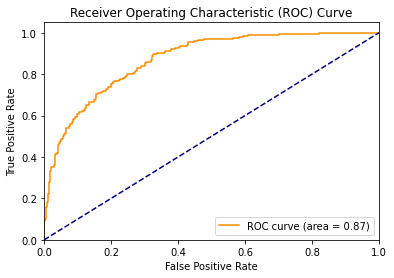

20/20 [==============================] - 0s 839us/step
Sigmoid Model:


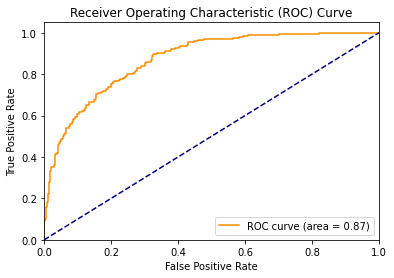

20/20 [==============================] - 0s 906us/step
Tanh Model:


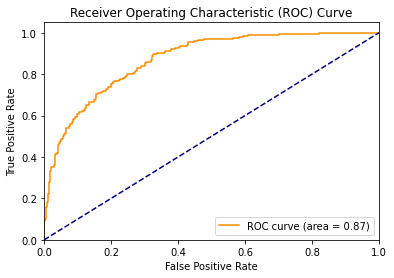

In [10]:
# Predict the train data
def predict_data(model, data):
    return model.predict(data).flatten()

y_pred_relu = predict_data(best_relu_model, X_train)
y_pred_sigmoid = predict_data(best_sigmoid_model, X_train)
y_pred_tanh = predict_data(best_tanh_model, X_train)

# Compute the metrics
def get_metrics(y_true, y_pred, threshold=0.5):
    y_pred_label = [1 if i > threshold else 0 for i in y_pred]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_label).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, sensitivity, specificity, roc_auc

metrics_relu = get_metrics(y_train, y_pred_relu)
metrics_sigmoid = get_metrics(y_train, y_pred_sigmoid)
metrics_tanh = get_metrics(y_train, y_pred_tanh)

print("ReLU: Accuracy:", metrics_relu[0], "Sensitivity:", metrics_relu[1], "Specificity:", metrics_relu[2], "ROC AUC:", metrics_relu[3])
print("Sigmoid: Accuracy:", metrics_sigmoid[0], "Sensitivity:", metrics_sigmoid[1], "Specificity:", metrics_sigmoid[2], "ROC AUC:", metrics_sigmoid[3])
print("Tanh: Accuracy:", metrics_tanh[0], "Sensitivity:", metrics_tanh[1], "Specificity:", metrics_tanh[2], "ROC AUC:", metrics_tanh[3])

# Function to plot the ROC curve
def plot_roc_curve(outputs, labels):
    fpr, tpr, _ = roc_curve(labels, outputs)
    roc_auc = roc_auc_score(labels, outputs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Predictions for the ReLU model
y_pred_relu = best_relu_model.predict(X_train).ravel()
print("ReLU Model:")
plot_roc_curve(y_pred_relu, y_train)

# Predictions for the Sigmoid model
y_pred_sigmoid = best_sigmoid_model.predict(X_train).ravel()
print("Sigmoid Model:")
plot_roc_curve(y_pred_sigmoid, y_train)

# Predictions for the Tanh model
y_pred_tanh = best_tanh_model.predict(X_train).ravel()
print("Tanh Model:")
plot_roc_curve(y_pred_tanh, y_train)

5/5 [==============================] - 0s 998us/step
ReLU: Accuracy: 0.7662337662337663 Sensitivity: 0.5740740740740741 Specificity: 0.87 ROC AUC: 0.8346296296296296
Sigmoid: Accuracy: 0.7662337662337663 Sensitivity: 0.5740740740740741 Specificity: 0.87 ROC AUC: 0.8346296296296296
Tanh: Accuracy: 0.7662337662337663 Sensitivity: 0.5740740740740741 Specificity: 0.87 ROC AUC: 0.8346296296296296
5/5 [==============================] - 0s 749us/step
ReLU Model:


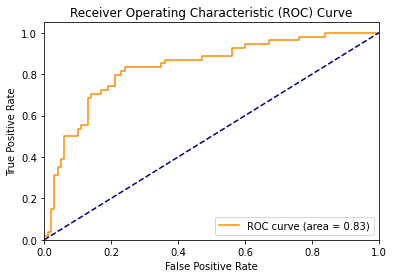

5/5 [==============================] - 0s 999us/step
Sigmoid Model:


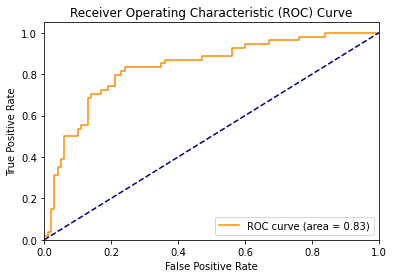

5/5 [==============================] - 0s 998us/step
Tanh Model:


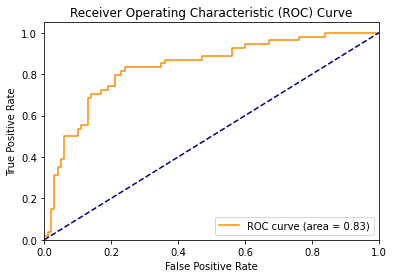

In [11]:
y_pred_relu = predict_data(best_relu_model, X_test)
y_pred_sigmoid = predict_data(best_sigmoid_model,  X_test)
y_pred_tanh = predict_data(best_tanh_model,  X_test)

metrics_relu = get_metrics(y_test, y_pred_relu)
metrics_sigmoid = get_metrics(y_test, y_pred_sigmoid)
metrics_tanh = get_metrics(y_test, y_pred_tanh)

print("ReLU: Accuracy:", metrics_relu[0], "Sensitivity:", metrics_relu[1], "Specificity:", metrics_relu[2], "ROC AUC:", metrics_relu[3])
print("Sigmoid: Accuracy:", metrics_sigmoid[0], "Sensitivity:", metrics_sigmoid[1], "Specificity:", metrics_sigmoid[2], "ROC AUC:", metrics_sigmoid[3])
print("Tanh: Accuracy:", metrics_tanh[0], "Sensitivity:", metrics_tanh[1], "Specificity:", metrics_tanh[2], "ROC AUC:", metrics_tanh[3])

# Predictions for the ReLU model
y_pred_relu = best_relu_model.predict(X_test).ravel()
print("ReLU Model:")
plot_roc_curve(y_pred_relu, y_test)

# Predictions for the Sigmoid model
y_pred_sigmoid = best_sigmoid_model.predict(X_test).ravel()
print("Sigmoid Model:")
plot_roc_curve(y_pred_sigmoid, y_test)

# Predictions for the Tanh model
y_pred_tanh = best_tanh_model.predict(X_test).ravel()
print("Tanh Model:")
plot_roc_curve(y_pred_tanh, y_test)